# AP4 - Apprentissage machine et classification d'ondes cérébrales

## Introduction de l'activité

Avant de plonger directement dans l'analyse des données, il est essentiel de définir quelles caractéristiques du signal nous allons utiliser et de choisir un modèle approprié.

Tous les algorithmes d'apprentissage automatique ne sont pas égaux face à différents ensembles de données. Par exemple, les forêts et les arbres de classification sont plus efficaces sur des données comportant de nombreuses caractéristiques, contrairement aux SVM qui peuvent souffrir davantage du fléau de la dimensionnalité.

Il est également crucial de se demander si la quantité de données dont nous disposons est suffisante pour étayer l'hypothèse que nous souhaitons vérifier. Bien que des tests statistiques puissent parfois être utilisés pour valider un résultat obtenu avec un petit ensemble de données, en neuroscience, les données sont souvent coûteuses et donc limitées en nombre. Il n'est donc pas rare de devoir recourir à des techniques d'augmentation des données pour compenser ce manque.

Dans le cas présent, nous allons explorer différents modèles pour tenter de résoudre divers problèmes en utilisant le même jeu de données. Pour ce faire, nous utiliserons la bibliothèque <a href="https://scikit-learn.org/stable/">scikit-learn</a>, qui offre une approche relativement simple pour utiliser divers algorithmes d'apprentissage automatique."

In [1]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Classification gauche-droite
Dans cette étape, nous nous pencherons sur la réalisation d'une classification de nos données afin de déterminer si le sujet a entendu un stimulus à gauche ou à droite. Dans une approche guidée par les données (data-driven), nous ne formulerons pas d'hypothèses préalables sur les résultats.

Pour chaque capteur, nous tenterons de distinguer les stimuli à gauche des stimuli à droite en utilisant les valeurs de la densité spectrale de puissance (PSD) que nous avons calculées lors de l'AP3.

### Chargement des données
Dans les méthodes de classification, qui relèvent de l'apprentissage machine supervisé, l'utilisation de deux matrices est nécessaire :

- Une matrice de données, souvent appelée X, qui contient les données utilisées pour l'apprentissage et le test de l'algorithme d'apprentissage machine.
- Une matrice d'étiquettes ou de cibles, souvent appelée y, qui contient l'information que l'on souhaite prédire, encodée en chiffres.

Dans notre exemple, où nous souhaitons effectuer une classification entre les stimuli gauche et droite, nous allons associer arbitrairement les valeurs 0 ou 1 à chacune de nos classes. Par exemple : 0 correspond à gauche et 1 à droite.

In [2]:
conditions = ['visualleft', 'visualright']
data_path = mne.datasets.sample.data_path()
data = []
cibles = []  # Liste des cibles associées à chaque condition
for i, condition in enumerate(conditions):
    # Chargement des données PSD préalablement calculées pour chaque condition
    temp_data = np.load(os.path.join(data_path, 'MEG', 'sample', f'{condition}_psds_bands.npy'))
    cibles += [i] * temp_data.shape[1]  # Répétition des cibles pour chaque échantillon
    data.append(temp_data)

# Création de la matrice de données (X) et du vecteur de cibles (y)
X = np.concatenate(data, axis=1)  # Concaténation des données PSD
y = np.array(cibles)  # Conversion de la liste des cibles en un tableau numpy


### Choix de l'algorithme

Pour débuter, nous allons utiliser l'algorithme des k plus proches voisins "K Nearest Neighbors" (KNN). C'est un algorithme simple et rapide à exécuter qui possède un seul hyperparamètre.

Dans un premier temps, nous allons évaluer les performances de l'algorithme sans nous préoccuper de l'optimisation des hyperparamètres, mais nous reviendrons sur ce concept plus tard.

In [3]:
from sklearn.neighbors import KNeighborsClassifier as KNN

clf = KNN()

### Choix de la méthode de validation

Il est maintenant essentiel de sélectionner une méthode nous permettant d'évaluer au mieux les performances de notre algorithme. Ce choix revêt une grande importance, car une méthode de validation inappropriée peut avoir un impact significatif sur nos résultats.

La méthode choisie déterminera la manière dont nous diviserons nos données pour entraîner notre algorithme sur une partie et le tester sur une autre. Elle est indispensable, car elle nous permet de contrôler le surapprentissage (overfitting).

La méthode la plus simple consiste à diviser nos données en deux parties distinctes : l'ensemble d'entraînement (train) et l'ensemble de validation ou de test, ce que l'on appelle la "Holdout method" :

#### Méthode Holdout

Dans cette approche, les données sont divisées de manière arbitraire en deux parties 80% pour le train et 20% pour le test:

In [4]:
X_train = X[:72]
y_train = y[:72]

X_test = X[72:]
y_test = y[72:]

Immédiatement, si l'on affiche les labels de nos données, on remarque un problème : notre ensemble d'entraînement ne contient que des exemples de stimuli orientés vers la gauche, ce qui signifie qu'il sera incapable d'apprendre à distinguer entre la gauche et la droite !

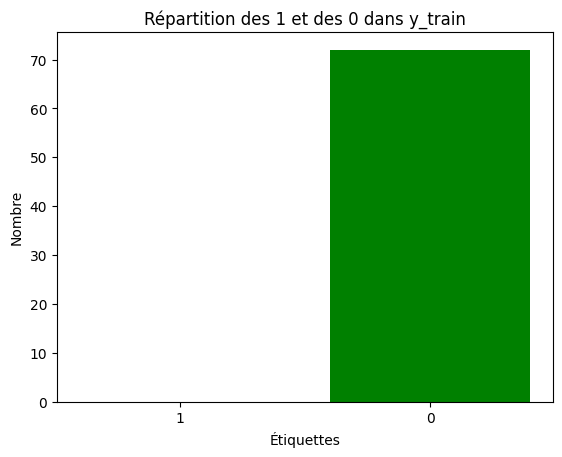

In [5]:
# Compter le nombre d'occurrences de 1 et 0 dans y_train
compte_1 = sum(label == 1 for label in y_train)
compte_0 = len(y_train) - compte_1

# Créer un diagramme à barres
plt.bar(['1', '0'], [compte_1, compte_0], color=['blue', 'green'])
plt.xlabel('Étiquettes')
plt.ylabel('Nombre')
plt.title('Répartition des 1 et des 0 dans y_train')
plt.show()

Par conséquent, il est essentiel de sélectionner aléatoirement des échantillons à partir de l'ensemble de données initial ou de le mélanger de manière aléatoire avant de tirer les échantillons. Pour ce faire, nous créons un index pour les données que nous allons mélanger. Il est crucial d'appliquer exactement le même mélange à la fois sur les données et les étiquettes. Sinon, nous risquerions de perdre la correspondance entre chaque exemple et sa catégorie, ce qui compromettrait sérieusement l'intégrité de notre ensemble de données.

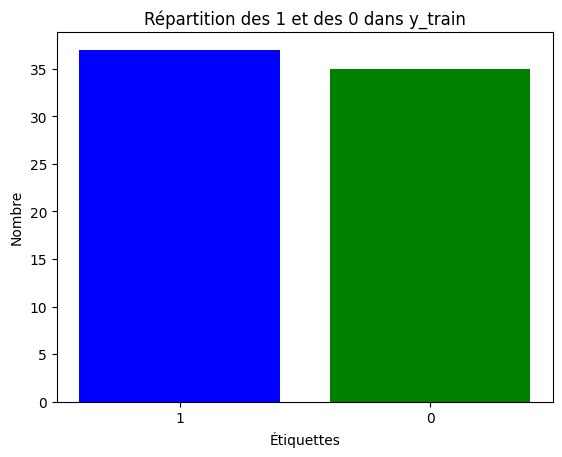

In [6]:
# Création de l'index:
index = np.arange(X.shape[1])

# mélange de l'index:
np.random.shuffle(index)

# On applique le mélange aux données et aux labels:
shuffled_X = X[:,index]
shuffled_y = y[index]

# On effectue notre séparation (split) à nouveau:
X_train = shuffled_X[:,:72]
y_train = shuffled_y[:72]

X_test = shuffled_X[:,72:]
y_test = shuffled_y[72:]

# Affichons à nouveau nos labels d'entraînement pour vérifier:
# Compter le nombre d'occurrences de 1 et 0 dans y_train
compte_1 = sum(label == 1 for label in y_train)
compte_0 = len(y_train) - compte_1

# Créer un diagramme à barres
plt.bar(['1', '0'], [compte_1, compte_0], color=['blue', 'green'])
plt.xlabel('Étiquettes')
plt.ylabel('Nombre')
plt.title('Répartition des 1 et des 0 dans y_train')
plt.show()

En pratique, scikit-learn implémente des fonctions qui vont faciliter ce travail :

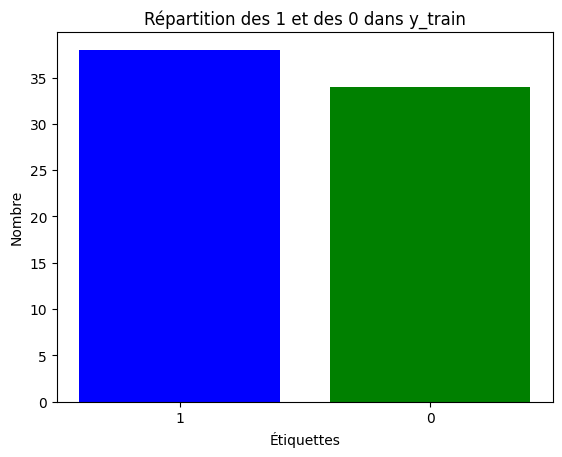

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.swapaxes(0,1), y, test_size=72, random_state=42)
X_train = X_train.swapaxes(0,1)
X_test = X_test.swapaxes(0,1)

# Affichons à nouveau nos labels d'entraînement pour vérifier:
# Compter le nombre d'occurrences de 1 et 0 dans y_train
compte_1 = sum(label == 1 for label in y_train)
compte_0 = len(y_train) - compte_1

# Créer un diagramme à barres
plt.bar(['1', '0'], [compte_1, compte_0], color=['blue', 'green'])
plt.xlabel('Étiquettes')
plt.ylabel('Nombre')
plt.title('Répartition des 1 et des 0 dans y_train')
plt.show()

**Note** : Ici, nous sommes obligés d'utiliser [swapaxes](https://numpy.org/doc/stable/reference/generated/numpy.swapaxes.html) car la première dimension de nos données doit être celle qui liste les exemples. Actuellement, la première dimension correspond aux électrodes.

**Note 2** : Étant donné que le mélange des données est aléatoire, il est possible, par malchance, d'obtenir un découpage qui favorise une classe dans `X_train` et `y_train`. Cela peut être contrôlé en utilisant une option de la fonction. Consultez la [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) pour plus d'informations.

**Note 3** : À chaque exécution du code, un mélange différent est obtenu. Le comportement du mélange peut être contrôlé si l'on souhaite reproduire exactement la même expérience en fixant une valeur de "random_state". Consultez la [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) pour plus de détails.

Passons maintenant à l'évaluation des performances de notre modèle sur ce problème spécifique. Notre objectif est de déterminer quelle électrode ou combinaison d'électrodes est la plus efficace pour distinguer les stimuli orientés vers la gauche ou vers la droite. Commençons par examiner la première électrode de notre liste.

In [8]:
# On sélectionne par exemple l'électrode 0 (1er canal, puisque Python commence à 0)
electrode = 0

Entraînons maintenant le modèle sur le dataset d'entraînement:

In [9]:
# On a deja créé notre classifieur KNN, on peut donc l'entraîner sur les données d'entraînement
# Pour cela, on utilise la méthode fit() de notre classifieur
# Qui prend en paramètres les données d'entraînement (X_train) et les labels d'entraînement (y_train)
clf.fit(X_train[electrode], y_train)

KNeighborsClassifier()

Utilisons ensuite le modèle entraîné pour prédire les classes du dataset de test:

In [10]:
# Pour cela, on utilise la méthode predict() de notre classifieur
# Qui prend en paramètres les données de test (X_test)
# Et qui retourne les prédictions (y_pred)
y_pred = clf.predict(X_test[electrode])

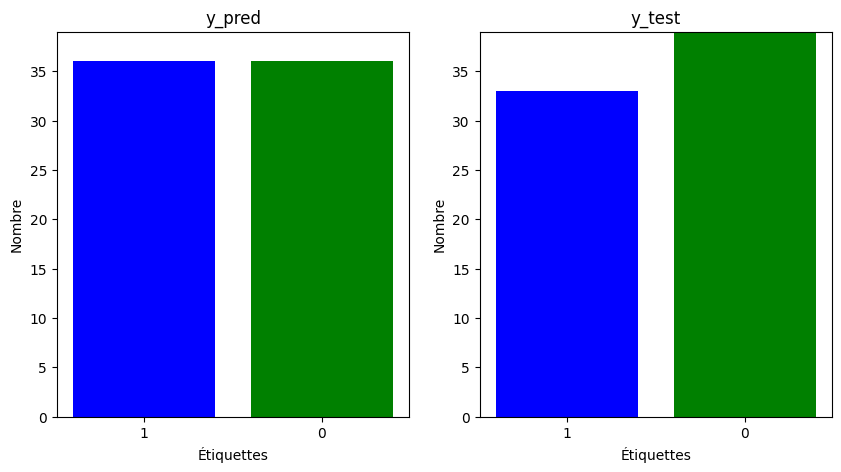

In [11]:
# Comptons le nombre d'occurrences de 1 et 0 dans y_pred et y_test
compte_pred_1 = sum(label == 1 for label in y_pred)
compte_pred_0 = len(y_pred) - compte_pred_1

compte_test_1 = sum(label == 1 for label in y_test)
compte_test_0 = len(y_test) - compte_test_1

# Créons deux graphiques à barres côte à côte
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Premier graphique : y_pred
ax1.bar(['1', '0'], [compte_pred_1, compte_pred_0], color=['blue', 'green'])
ax1.set_xlabel('Étiquettes')
ax1.set_ylabel('Nombre')
ax1.set_title('y_pred')
ax1.set_ylim([0, max(compte_pred_1, compte_pred_0, compte_test_1, compte_test_0)])

# Deuxième graphique : y_test
ax2.bar(['1', '0'], [compte_test_1, compte_test_0], color=['blue', 'green'])
ax2.set_xlabel('Étiquettes')
ax2.set_ylabel('Nombre')
ax2.set_title('y_test')
ax2.set_ylim([0, max(compte_pred_1, compte_pred_0, compte_test_1, compte_test_0)])

plt.show()

Ce code crée deux graphiques à barres, l'un pour y_pred et l'autre pour y_test. Les barres bleues représentent le nombre de prédictions ou d'étiquettes égales à 1, tandis que les barres vertes représentent le nombre de prédictions ou d'étiquettes égales à 0. Ces graphiques permettent de comparer visuellement les différences entre les prédictions du modèle (y_pred) et les valeurs réelles (y_test). Une différence significative entre ces deux ensembles peut indiquer des erreurs de prédiction ou des points de données mal classés.

Pour mesurer les performances de notre algorithme, nous pouvons simplement calculer son erreur et sa précision. Pour ce faire, il suffit de calculer l'erreur à l'aide de la formule :

$$ \text{erreur} = \frac{\sum|\text{valeur absolue}(y_{\text{pred}} - y_{\text{test}})|}{\text{nombre de prédictions}} $$

Ensuite, la précision $$\textit{accuracy}$$ peut être calculée comme suit :

$$ \text{accuracy} = 1 - \text{erreur} $$

In [12]:
# Calcul de l'erreur
error = sum(abs(y_pred - y_test)) / len(y_pred)

# Calcul de l'Précision (accuracy)
accuracy = 1 - error

# Affichage de l'Précision
print(f"Accuracy : {accuracy:.3f}")


Accuracy : 0.458


Notre précision est de 45.8%. Bien qu'il existe d'autres mesures de performance du modèle, dans notre cas, la précision est la plus appropriée.

Étant donné que notre problème est de nature binaire, le niveau de chance théorique est de 50%. Cela signifie que notre résultat est légèrement en dessous du niveau de chance, suggérant que notre modèle pourrait ne pas être capable de distinguer de manière fiable entre les stimuli orientés vers la gauche et ceux orientés vers la droite avec les caractéristiques du signal capturées par cette électrode spécifique.

Cependant, il est important de noter que le niveau de chance théorique n'est pas la référence appropriée compte tenu de notre petite taille d'échantillon. Nous devons évaluer la pertinence statistique de ce résultat. Nous reviendrons sur cette partie ultérieurement.

Pour explorer d'autres métriques de performance, veuillez consulter [ici](https://en.wikipedia.org/wiki/Fairness_(machine_learning)).

Encore une fois, en pratique, il est beaucoup plus simple d'utiliser directement une fonction fournie par scikit-learn pour calculer la précision de notre modèle."

In [13]:
# Calcul de l'erreur
score = clf.score(X_test[electrode], y_test)

# Affichage de l'Précision
print(f"Précision du modèle :{score:.3f}")

Précision du modèle :0.458


In [ ]:
# Question 1: Refaites l'entraînement et la prédiction avec d'autres électrodes (2 où 3). Quelle est la précision du modèle?
ADD CODE HERE

Le problème de la méthode de la "Holdout" est qu'elle peut nous avantager ou désavantager de manière aléatoire, surtout lorsqu'elle est appliquée sur un petit dataset. Pour atténuer cet impact du hasard, nous allons utiliser des techniques de "cross-validation". La cross-validation implique la répétition du processus de découpage des données plusieurs fois, minimisant ainsi l'effet du hasard dans l'évaluation des performances de notre algorithme.

### Cross-validation : K-Fold

Voici quelques méthodes courantes de cross-validation :

- **Leave One Out (LOO)** : Cette méthode implique de laisser de côté un seul exemple de notre jeu de données pour les tests et de garder tous les autres pour l'entraînement. Bien qu'elle permette de mesurer avec précision la performance d'un algorithme, elle est rarement utilisée en pratique. Elle est exhaustive, testant toutes les combinaisons possibles de jeux d'entraînement et de test. Bien que cela ne pose pas de problème pour notre petit jeu de données (seulement 140 exemples), cela peut être un inconvénient lorsque le nombre d'exemples est beaucoup plus élevé, car l'entraînement et les tests de l'algorithme prennent alors beaucoup de temps.

- **Leave P Out (LPO)** : Basée sur le même principe que LOO mais plus généralisée. Cette méthode teste sur plusieurs exemples à chaque itération, ce qui la rend plus précise. Cependant, elle devient encore plus problématique avec une augmentation de la taille des données, car il y a plus de combinaisons possibles de "p" parmi "n" que de combinaisons de "1" parmi "n".

- **K-Fold** : Cette méthode consiste à diviser les données en K sous-ensembles, en utilisant K-1 d'entre eux comme ensemble d'entraînement et le reste comme ensemble de test. K-Fold est souvent préférée, car elle est plus rapide que les méthodes précédentes, tout en fournissant une estimation acceptable de la performance de l'algorithme. 

Nous allons utiliser la méthode K-Fold, car elle est relativement rapide tout en restant appropriée pour notre problème. En pratique, nous utilisons la version "stratifiée" de K-Fold pour nous assurer que chaque sous-ensemble du jeu de données contient un nombre égal d'exemples de chaque condition. Sans cela, il serait possible, par pure chance, d'avoir quelques sous-ensembles de données contenant uniquement une seule condition, ce qui fausserait les résultats.

Nous allons choisir la valeur par défaut de K = n_splits = 5, ce qui nous permettra d'obtenir 5 scores de précision pour notre algorithme. Il sera entraîné sur 4/5 (80%) de nos données et testé sur le reste (20%).

In [14]:
from sklearn.model_selection import StratifiedKFold as SKFold

cv = SKFold(n_splits=5)

Concrètement, cette méthode va répéter le processus de découpage entre l'ensemble d'entraînement et l'ensemble de test que nous avons effectué manuellement précédemment. Au lieu d'obtenir un seul score de précision pour chaque électrode, nous pouvons en obtenir plusieurs à partir des différents découpages et les moyenne. Cela nous permet d'obtenir un résultat plus robuste et représentatif de la performance de notre algorithme.

Lorsque nous appliquons l'étape de cross-validation avec notre objet `cv`, nous reproduisons essentiellement ce que nous avons fait manuellement précédemment. Les multiples scores de précision obtenus peuvent ensuite être utilisés pour évaluer la performance de notre modèle de manière plus fiable et significative.

In [15]:
# Obtention des indices pour l'entraînement et le test à partir de la cross-validation (cv)
train_index, test_index = next(cv.split(X[electrode], y))

# Séparation des données en ensembles d'entraînement et de test en utilisant les indices obtenus
X_train = X[electrode][train_index]  # Caractéristiques d'entraînement
y_train = y[train_index]  # Étiquettes d'entraînement
X_test = X[electrode][test_index]  # Caractéristiques de test
y_test = y[test_index]  # Étiquettes de test

# Initialisation et entraînement du classifieur KNN (K-Nearest Neighbors) sur les données d'entraînement
clf = KNN()  # Création d'un classifieur KNN
clf.fit(X_train, y_train)  # Entraînement du classifieur sur les données d'entraînement

# Calcul du score de précision du modèle sur les données de test
accuracy = clf.score(X_test, y_test)  # Score de précision du modèle sur les données de test
print(f"Accuracy du modèle sur les données de test : {accuracy:.3f}")  # Affichage du score de accuracy


Accuracy du modèle sur les données de test : 0.310


On souhaite reproduire la cellule précédente pour chaque sous-ensemble de données. Il suffit de stocker les résultats dans une liste au fur et à mesure:

In [16]:
# Initialisation d'une liste pour stocker les scores de précision
scores = []

# Boucle à travers chaque sous-ensemble de données généré par la cross-validation
for train_index, test_index in cv.split(X[electrode], y):
    # Séparation des données en ensembles d'entraînement et de test en utilisant les indices obtenus
    X_train = X[electrode][train_index]  # Caractéristiques d'entraînement
    y_train = y[train_index]  # Étiquettes d'entraînement
    X_test = X[electrode][test_index]  # Caractéristiques de test
    y_test = y[test_index]  # Étiquettes de test
    
    # Initialisation et entraînement du classifieur KNN (K-Nearest Neighbors) sur les données d'entraînement
    clf = KNN()  # Création d'un classifieur KNN
    clf.fit(X_train, y_train)  # Entraînement du classifieur sur les données d'entraînement
    
    # Calcul du score de précision du modèle sur les données de test et ajout du score à la liste des scores
    score = clf.score(X_test, y_test)  # Score de précision du modèle sur les données de test
    scores.append(score)  # Ajout du score à la liste des scores
    
# Affichage des scores de précision obtenus pour chaque sous-ensemble de données
print("Scores de précision pour chaque sous-ensemble de données:", scores)

Scores de précision pour chaque sous-ensemble de données: [0.3103448275862069, 0.3793103448275862, 0.5517241379310345, 0.3103448275862069, 0.5714285714285714]


On obtient ainsi 5 scores correspondant aux 5 découpages que nous avions configurés dans l'objet de validation croisée.

On remarque ici que le score de précision de notre modèle varie considérablement en fonction du découpage effectué ! Il est évident que notre précédent score de 45,8 % était le fruit du hasard, et c'est une bonne décision d'avoir changé notre méthode de validation. Il est également important de noter que la taille de l'ensemble d'entraînement était différente dans notre expérience précédente avec la méthode de Holdout, ce qui peut avoir un impact significatif sur le score final du modèle.

Calculons maintenant la moyenne des scores de précision de notre modèle pour la première électrode :

In [17]:
# Calcul de la moyenne des scores de précision obtenus
score_moyen = np.mean(scores)  # Calcul de la moyenne des scores à partir de la liste 'scores'

# Affichage du score moyen de précision du modèle pour la première électrode
print(f"Score moyen de précision pour la première électrode : {score_moyen:.3f}")

Score moyen de précision pour la première électrode : 0.425


Pour approfondir notre analyse, nous devons désormais calculer la précision de notre modèle pour chaque électrode. Avant cela, nous utiliserons une fonction de haut niveau de sklearn qui simplifiera notre code, car elle nous permettra d'effectuer la validation croisée en une seule ligne :

In [18]:
from sklearn.model_selection import cross_val_score

clf = KNN()
cv = SKFold(n_splits=5)
scores = cross_val_score(clf, X[electrode], y, cv=cv)
print(f"Score moyen de précision pour la première électrode : {np.mean(scores):.3f}")

Score moyen de précision pour la première électrode : 0.425


Notre score moyen est nettement inférieur au niveau de chance ! On peut presque conclure que cette électrode ne capture pas d'informations pertinentes pour différencier les stimuli de gauche et de droite.


In [30]:
# Question 2: Refaites la cross-validation avec d'autres électrodes (2 où 3). Quelle est la précision du modèle?

Faire des évaluations pour chaque électrode individuellement n'est pas la méthode la plus optimale. De plus, effectuer une sélection arbitraire n'a pas de sens dans ce contexte. Pour résoudre ce problème, nous allons répéter les étapes précédentes pour chaque électrode et évaluer la pertinence statistique de nos résultats.

In [19]:
# Calcul du nombre total d'électrodes dans X
n_elec = len(X)  # Nombre total d'électrodes

# Initialisation d'une liste pour stocker les scores de précision moyens pour chaque électrode
scores_elec = []

# Boucle à travers chaque électrode dans X
for electrode in range(n_elec):
    # Initialisation d'un classifieur KNN
    clf = KNN()  # Création d'un classifieur KNN
    
    # Initialisation d'un objet de validation croisée K-Fold avec 5 splits
    cv = SKFold(n_splits=5)  # Création d'un objet de validation croisée avec 5 splits
    
    # Calcul des scores de précision pour l'électrode actuelle en utilisant la cross-validation
    scores = cross_val_score(clf, X[electrode], y, cv=cv)  # Calcul des scores de précision à partir de la cross-validation
    
    # Calcul de la moyenne des scores de précision obtenus pour l'électrode actuelle
    score_moyen_elec = np.mean(scores)  # Calcul de la moyenne des scores à partir de la liste 'scores'
    
    # Ajout du score moyen de précision de l'électrode à la liste des scores pour chaque électrode
    scores_elec.append(score_moyen_elec)  # Ajout du score moyen de précision de l'électrode à la liste 'scores_elec'

# Conversion de la liste des scores de précision moyens en un tableau NumPy
scores_elec = np.array(scores_elec)  # Conversion de la liste en un tableau NumPy pour une manipulation facile

Visualisons les résultats que nous avons obtenus sur une topomap:

Opening raw data file /Users/hamzaabdelhedi/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


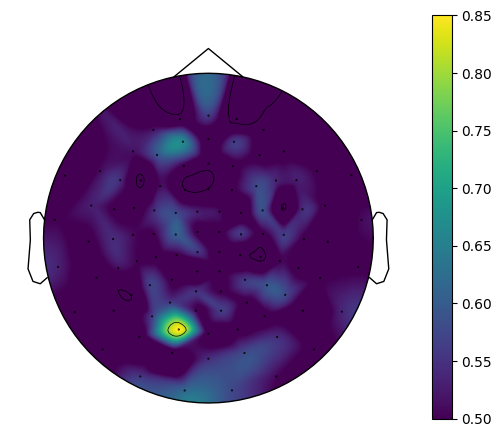

In [20]:
# Chargement des données de position des capteurs:
data_path = mne.datasets.sample.data_path()  # Chemin vers les données du capteur
raw = mne.io.read_raw_fif(
    os.path.join(data_path, 'MEG', 'sample', 'sample_audvis_raw.fif'), preload=False)  # Lecture des données brutes du capteur
info = raw.pick_types(meg='mag').info  # Sélection des types de capteurs MEG et récupération des informations

# Création et affichage de la topographie :
fig, ax = plt.subplots()  # Création d'une nouvelle figure et de ses axes
im, cn = mne.viz.plot_topomap(
    scores_elec,
    info,
    res=128,  # Résolution de la topographie
    cmap="viridis",  # Colormap utilisée pour la représentation
    vlim=[.5, .85],  # Limites de l'échelle de couleur
    show=False,  # Ne pas afficher immédiatement la topographie
    contours=1,  # Niveau de contour
    extrapolate="head",  # Extrapolation de la topographie à la tête
    sphere=0.18,  # Rayon de la sphère pour l'extrapolation
    axes=ax,  # Utilisation des axes définis précédemment
)
cb = fig.colorbar(im)  # Ajout d'une barre de couleur à la figure pour indiquer les valeurs de la colormap

On remarque qu'il semble que l'on aurait de bons résultats dans la région occipitale. Il n'est pas encore possible de conclure avant d'avoir effectué des tests statistiques, même si ces résultats sont une bonne indication que tout a bien fonctionné. Voyons donc quel est notre meilleur score :

In [21]:
meilleur_score = max(scores_elec)
print(f"Le meilleur score obtenu est : {meilleur_score:.3f}")

Le meilleur score obtenu est : 0.854


Pouvons-nous obtenir de meilleurs résultats ?

Dans un pipeline d'apprentissage machine, nous testons généralement plusieurs modèles pour sélectionner celui qui offre la meilleure précision. Ensuite, nous tentons d'optimiser les hyperparamètres de ce modèle pour obtenir le meilleur résultat.

Par exemple pour KNN on peut trouver la documentation du modèle et ses hyperparamètres [ici.]( https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn-neighbors-kneighborsclassifier)

In [42]:
# Question 3: Essayer de changer le nombre de neighbors (n_neighbors) dans le classifieur KNN. Refaites toutes les étapes précédentes de cross-validation.
# Quelle est la meilleure précision que vous avez obtenue?
# Hint: clf = KNN(n_neighbors=ADD CODE HERE)

In [43]:
# Question 4: Essayer d'utiliser un autre classifieur SVM. Quelle est la précision du modèle? Refaites toutes les étapes précédentes de cross-validation.
# Quelle est la meilleure précision que vous avez obtenue?
# Hint: from sklearn.svm import SVC

In [44]:
# Question 5: Essayer de changer les hyperparamètres du classifieur SVM. Quelle est la meilleure précision que vous avez obtenue?
#HINT: clf = SVC(kernel='ADD CODE HERE', C=ADD CODE HERE, gamma=ADD CODE HERE)

Avant d'effectuer des tests statistiques, nous allons créer une matrice de confusion afin de déterminer si nous pouvons obtenir des informations supplémentaires sur l'électrode pour laquelle notre modèle performe le mieux.

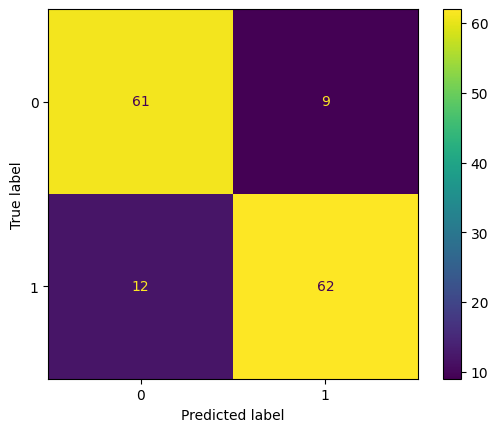

In [22]:
# Obtenir l'index de l'électrode qui donne la meilleure précision:
best = np.argmax(scores_elec)

# création des données nécessaires pour la matrice de confusion, 
# il nous faut les prédictions et les labels originaux de tous nos splits de K-Fold:
cv = SKFold(n_splits=5)
y_true, y_pred = [], []
for train_index, test_index in cv.split(X[best], y):
    X_train = X[best][train_index]
    y_train = y[train_index]
    X_test = X[best][test_index]
    y_test = y[test_index]
    
    clf = KNN()
    clf.fit(X_train, y_train)
    y_pred += list(clf.predict(X_test)) # additionner des listes revient à les concaténer
    y_true += list(y_test)

# import de la fonction confusion_matrix de sklearn:
from sklearn.metrics import ConfusionMatrixDisplay as CM

# utilisation de la fonction:
CM.from_predictions(y_pred, y_true)
plt.show()

On ne remarque pas d'imbalance particulière dans la matrice de confusion. Cette matrice nous offre des indications précieuses sur la spécificité et la sensibilité du modèle. Pour en savoir davantage, veuillez cliquer [ici](https://fr.wikipedia.org/wiki/Sensibilit%C3%A9_et_sp%C3%A9cificit%C3%A9).

### Tests statistiques

En science des données, il est généralement recommandé d'avoir un grand nombre de données pour mieux modéliser et comprendre un phénomène. Malheureusement, dans les sciences médicales, les données sont souvent rares et coûteuses. Pour pallier ce problème, on peut recourir à des tests statistiques qui nous permettent de prouver que notre résultat n'est pas le fruit du hasard.

Une première approche est plus théorique et repose sur la loi binomiale. Cette loi nous permet d'évaluer la probabilité d'obtenir une série spécifique d'événements pour une variable aléatoire ayant une densité de probabilité donnée. Par exemple, elle nous permet de calculer la probabilité d'obtenir une seule fois le côté face dans une série de N tirages à pile ou face. Étant donné que nous effectuons une classification binaire, nous pourrions utiliser cette loi pour déterminer à quel point il est rare d'obtenir notre précision maximale de 83% si nous attribuions les conditions à chaque exemple de notre jeu de données au hasard.

Une autre méthode plus pratique consiste à effectuer des permutations de nos étiquettes y. Cela nous permet de mesurer combien de fois il serait possible d'obtenir notre résultat avec notre modèle uniquement par hasard.

Nous allons nous concentrer sur la deuxième méthode, plus fiable et intuitive, mais qui prend également plus de temps à calculer. En pratique, plus le nombre de permutations est élevé, plus nous pourrons affirmer que notre résultat est fiable. Pour les besoins de ce tutoriel, nous n'effectuerons que 100 permutations afin de pouvoir examiner nos résultats avant que le soleil ne se couche.

In [23]:
# Initialisation du nombre de permutations et de la liste pour stocker les scores permutés
n_permutations = 100
perm_scores = []

# Boucle à travers le nombre de permutations spécifié
for i in range(n_permutations):
    # Récupération du nombre d'électrodes (features) dans les données
    n_elec = len(X)
    
    # Liste pour stocker les scores pour chaque électrode pour cette permutation
    pscores_elec = []
    
    # Boucle à travers chaque électrode (feature)
    for electrode in range(n_elec):
        # Initialisation du classificateur K Nearest Neighbors et de la validation croisée
        clf = KNN()
        cv = SKFold(n_splits=5)
        
        # Mélange aléatoire des étiquettes y (labels)
        np.random.shuffle(y)
        
        # Calcul des scores de validation croisée pour l'électrode actuelle
        pscores = cross_val_score(clf, X[electrode], y, cv=cv)
        
        # Ajout de la moyenne des scores à la liste des scores pour cette électrode
        pscores_elec.append(np.mean(pscores))
    
    # Ajout des scores de cette permutation à la liste principale
    perm_scores.append(np.array(pscores_elec))

# Conversion de la liste en un tableau numpy
perm_scores = np.array(perm_scores)

Affichons les performances de notre modèle pour évaluer notre niveau de chance en nous concentrant sur notre meilleure électrode.

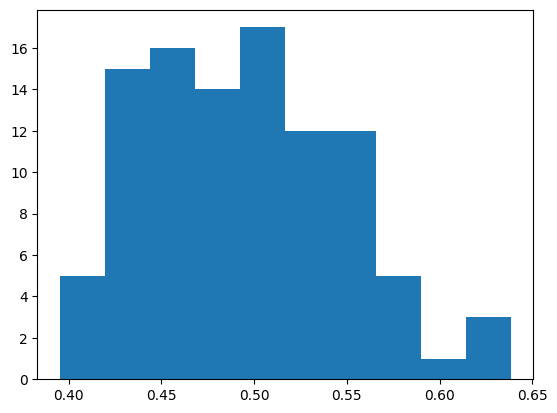

In [24]:
plt.hist(perm_scores[:,best])
plt.show()

Avec seulement 100 permutations, l'histogramme des scores de précision est relativement loin de la distribution réelle des scores de précision possibles. Avec un nombre infini de permutations, l'histogramme convergerait vers une gaussienne centrée sur le niveau de chance. Cependant, on remarque que notre score est bien supérieur aux 100 scores de permutations.

In [25]:
# Comparons le score de notre meilleure électrode avec le score maximal des permutations
best_electrode_score = scores_elec[best]
max_permutation_score = max(perm_scores[:, best])

# Vérifions si le score de notre meilleure électrode est supérieur au score maximal des permutations
is_better_than_permutation = best_electrode_score > max_permutation_score

# Affichons le résultat
print(f"Le score de notre meilleure électrode ({best_electrode_score:.2f}) est supérieur au score maximal des permutations ({max_permutation_score:.2f}): {is_better_than_permutation}")

Le score de notre meilleure électrode (0.85) est supérieur au score maximal des permutations (0.64): True


Ainsi, nous pouvons affirmer que notre résultat est statistiquement significatif à un niveau de signification de p=0.01.

our le confirmer et renforcer davantage notre résultat, il est nécessaire de vérifier que notre score est le meilleur parmi toutes les permutations, à travers toutes les électrodes. Cette vérification est appelée la correction par le maximum statistique.

Il existe d'autres méthodes de correction de valeurs p, telles que la méthode de [bonferroni](https://www.itl.nist.gov/div898/handbook/prc/section4/prc473.html), qui est plus stricte. La correction de Bonferroni ajuste les seuils de significativité en divisant le niveau de signification (généralement 0.05) par le nombre total de comparaisons effectuées, réduisant ainsi le risque de fausses découvertes.

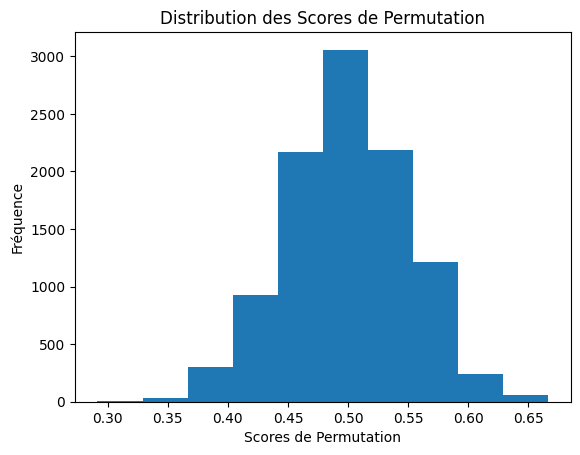

Le score observé est-il significatif ? True


In [26]:
# Aplatir la matrice des scores de permutation pour supprimer la dimension "électrode".
# Cette étape nous permet de comparer notre score à la distribution de tous les scores de permutation
# à travers toutes les électrodes.
scores_permutation_aplati = perm_scores.ravel()

# Tracer l'histogramme des scores de permutation aplaties.
plt.hist(scores_permutation_aplati)
plt.xlabel('Scores de Permutation')
plt.ylabel('Fréquence')
plt.title('Distribution des Scores de Permutation')
plt.show()

# Vérifier si notre score observé est supérieur au score maximal des permutations.
est_significatif = scores_elec[best] > max(scores_permutation_aplati)
print(f'Le score observé est-il significatif ? {est_significatif}')

Notre résultat est significatif à un seuil de p=0.01 après correction par le maximum statistique.

Maintenant, nous allons créer un masque pour tous nos résultats significatifs à p=0.01 et les afficher en utilisant ce masque sur notre topomap des decoding accuracies.

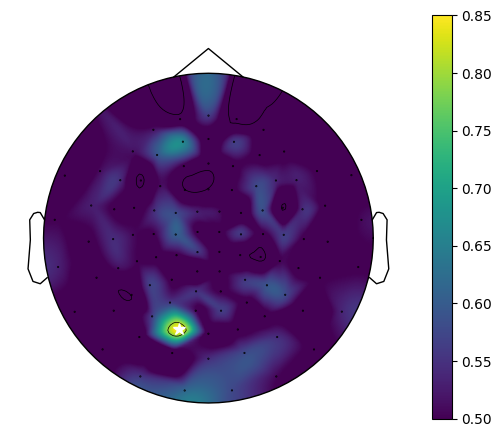

In [27]:
# création du masque
mask_params = dict(
    marker="*", markerfacecolor="white", markersize=9, markeredgecolor="white"
)
tt_mask = np.full((len(X)), False, dtype=bool)
tt_mask[scores_elec > max(perm_scores.ravel())] = True

# Création et affichage de la nouvelle topomap:
fig, ax = plt.subplots()
im, cn = mne.viz.plot_topomap(
    scores_elec,
    info,
    res=128,
    cmap="viridis",
    vlim=[.5, .85],
    show=False,
    mask=tt_mask, # On ajoute simplement ces deux lignes pour y inclure le masque
    mask_params=mask_params, # deuxieme ligne ajoutee au code topomap précédent
    contours=1,
    extrapolate="head",
    sphere=0.18,
    axes=ax,
)
cb = fig.colorbar(im)

On constate que notre seul résultat significatif à un seuil de p=0.01 est notre meilleur résultat.

In [28]:
# Pour cette analyse, on a utilisé les données de la tâche de visualisation gauche/droite.
# On peut également utiliser les données de la tâche de audition gauche/droite.
# Pour cela, vous devez s'assurer que les données sont déjà calculées (AP3 - Apprentissage machine et classification d'ondes cérébrales.ipynb).
# Question 6: Refaites toutes les étapes précédentes avec les données de la tâche de audition gauche/droite.
# Tester différents classifieurs et différents hyperparamètres.
# Quelle est la meilleure précision que vous avez obtenue?
# Quelle est la meilleure électrode? Est-ce que c'est la même que pour la tâche de visualisation gauche/droite?
# Observez-vous une différence entre les deux tâches?
# Ou bien, est-ce que les deux tâches sont similaires en termes de précision et de localisation de l'activité cérébrale?

## Conclusion

Pour améliorer encore nos résultats, il serait intéressant d'effectuer une optimisation des hyper-paramètres, bien que cela dépasse le cadre de ce tutoriel. Pour être concis, cette démarche nécessiterait de répéter les étapes de classification et d'évaluation du modèle pour différentes valeurs de K sur un sous-ensemble du jeu de données d'entraînement. Cela nous conduirait à utiliser une validation croisée à l'intérieur de notre validation croisée, ce qui est appelé des [nested cross-validations](https://www.analyticsvidhya.com/blog/2021/03/a-step-by-step-guide-to-nested-cross-validation/).

Il serait également pertinent d'analyser l'impact de chaque bande de fréquences utilisée dans notre classification. Jusqu'à présent, nous avons utilisé les quatre bandes sans évaluer la contribution de chacune d'entre elles. Cela relève d'une approche "multi-feature". Nous pourrions effectuer la classification sur chaque bande de fréquence individuellement afin de déterminer l'importance de chacune d'entre elles pour la distinction entre le stimulus visuel droit et le stimulus visuel gauche.

D'autres pistes d'amélioration pourraient inclure l'utilisation d'autres caractéristiques du signal, l'exploration de différentes combinaisons de ces caractéristiques, l'augmentation de la taille de l'ensemble de données, ainsi que l'inclusion de données provenant de plusieurs sujets pour obtenir des résultats plus robustes et généralisables. Les possibilités en recherche sont vastes, mais elles dépendent du temps et des ressources disponibles.

In [29]:
#Fin